In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.9723
Epoch 2/10
1/1 [==============================] - 1s 529ms/step - loss: 0.9003
Epoch 3/10
1/1 [==============================] - 0s 467ms/step - loss: 0.8588
Epoch 4/10
1/1 [==============================] - 0s 478ms/step - loss: 0.8311
Epoch 5/10
1/1 [==============================] - 0s 450ms/step - loss: 0.8059
Epoch 6/10
1/1 [==============================] - 0s 474ms/step - loss: 0.7574
Epoch 7/10
1/1 [==============================] - 0s 438ms/step - loss: 0.7271
Epoch 8/10
1/1 [==============================] - 0s 443ms/step - loss: 0.6751
Epoch 9/10
1/1 [==============================] - 1s 508ms/step - loss: 0.6579
Epoch 10/10
1/1 [==============================] - 0s 497ms/step - loss: 0.6562


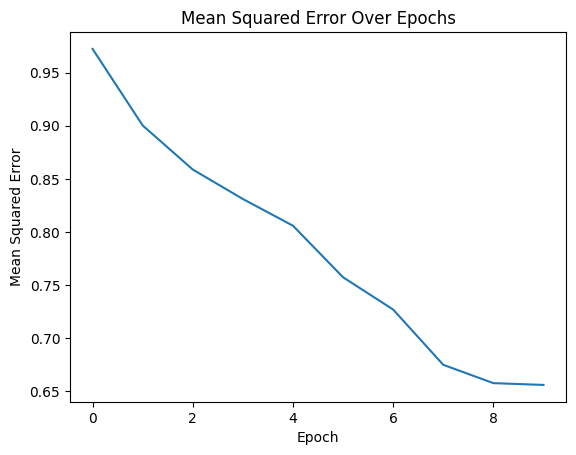

1/1 [==============================] - 0s 296ms/step
Accuracy Score: 98.16%


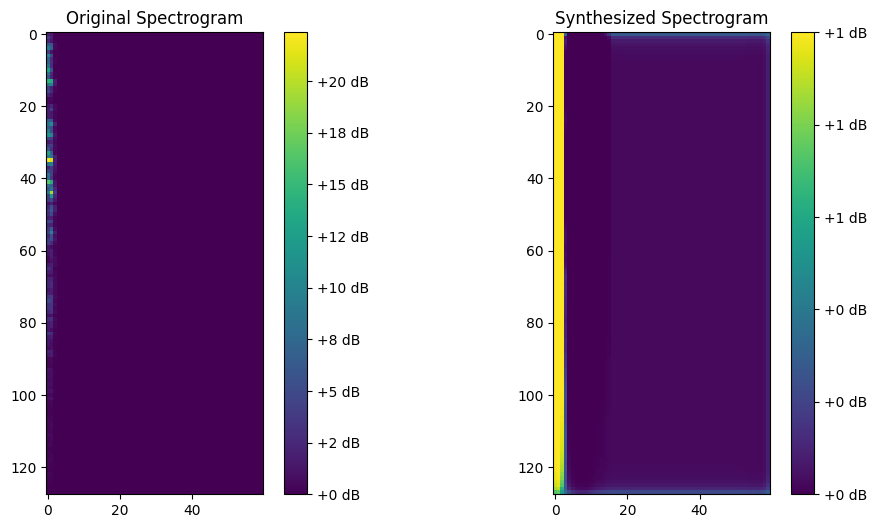

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.9686
Epoch 2/10
1/1 [==============================] - 1s 695ms/step - loss: 0.9000
Epoch 3/10
1/1 [==============================] - 1s 652ms/step - loss: 0.8590
Epoch 4/10
1/1 [==============================] - 1s 537ms/step - loss: 0.8297
Epoch 5/10
1/1 [==============================] - 0s 491ms/step - loss: 0.8046
Epoch 6/10
1/1 [==============================] - 0s 495ms/step - loss: 0.7570
Epoch 7/10
1/1 [==============================] - 0s 465ms/step - loss: 0.6962
Epoch 8/10
1/1 [==============================] - 0s 465ms/step - loss: 0.6593
Epoch 9/10
1/1 [==============================] - 0s 445ms/step - loss: 0.6531
Epoch 10/10
1/1 [==============================] - 0s 452ms/step - loss: 0.6523


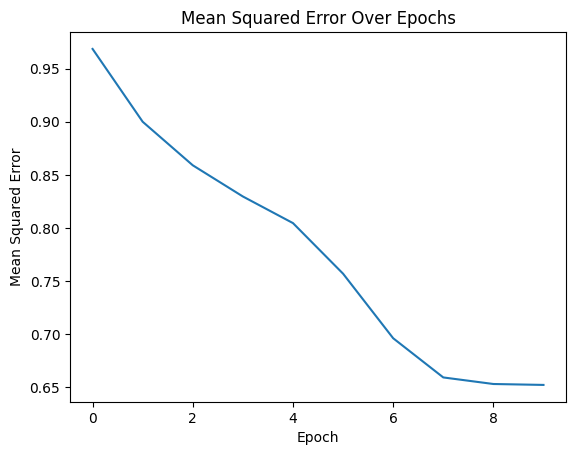

1/1 [==============================] - 0s 283ms/step
Accuracy Score: 98.89%


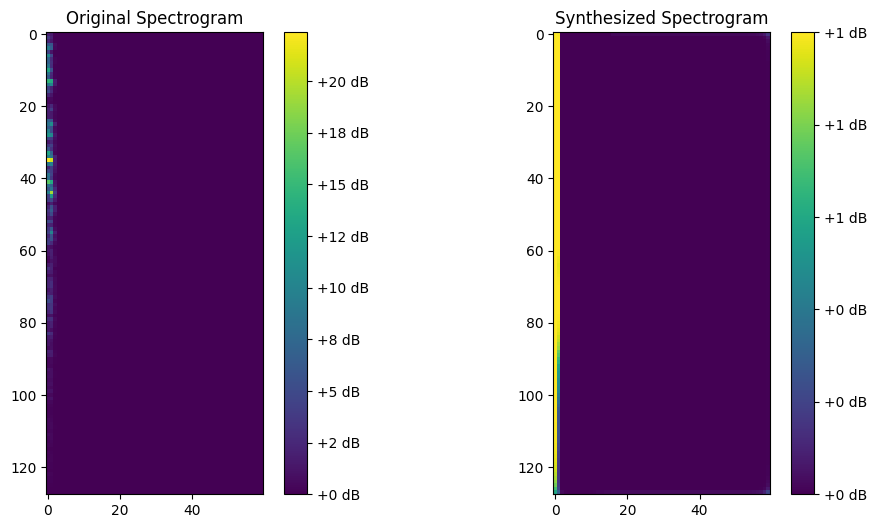

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.2414
Epoch 2/10
1/1 [==============================] - 0s 415ms/step - loss: 0.2110
Epoch 3/10
1/1 [==============================] - 0s 483ms/step - loss: 0.1585
Epoch 4/10
1/1 [==============================] - 1s 556ms/step - loss: 0.0938
Epoch 5/10
1/1 [==============================] - 1s 586ms/step - loss: 0.0412
Epoch 6/10
1/1 [==============================] - 1s 657ms/step - loss: 0.0260
Epoch 7/10
1/1 [==============================] - 1s 578ms/step - loss: 0.0241
Epoch 8/10
1/1 [==============================] - 1s 568ms/step - loss: 0.0239
Epoch 9/10
1/1 [==============================] - 0s 384ms/step - loss: 0.0239
Epoch 10/10
1/1 [==============================] - 0s 416ms/step - loss: 0.0239


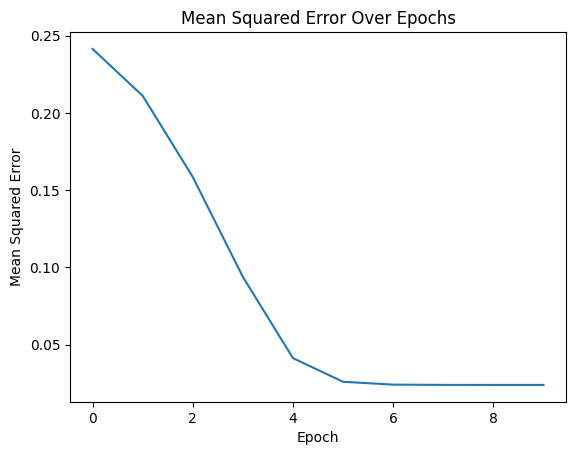

1/1 [==============================] - 0s 248ms/step
Accuracy Score: 98.46%


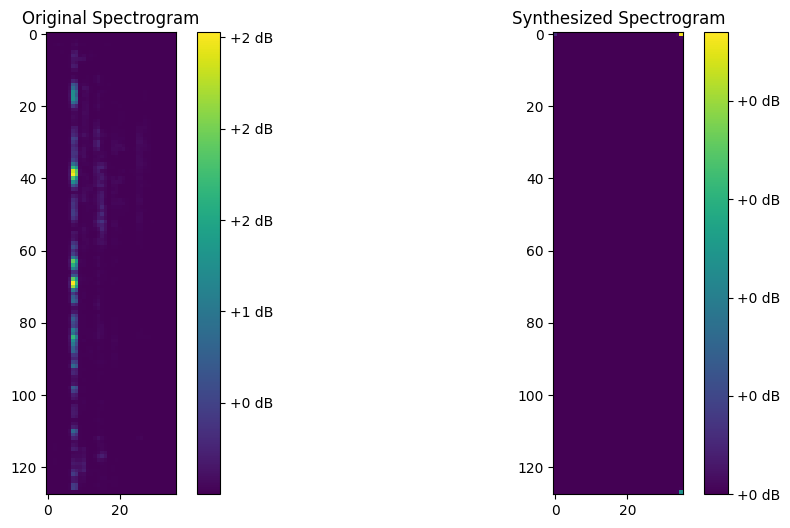

In [3]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ...

# توابع پیش‌پردازش
def load_and_preprocess_audio(file_path, target_sr=16000):
    audio, _ = librosa.load(file_path, sr=target_sr)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=target_sr)
    return np.array(spectrogram, dtype=np.float32)

# تعریف معماری شبکه عصبی
def autoencoder_model(input_shape):
    model = models.Sequential()

    # Encoder
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))

    # Decoder
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

    # Output layer
    model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

    return model


# تابع برای آموزش مدل بر روی یک فایل
def train_model(file_path, strategy, epochs=10):
    # بارگیری و پیش‌پردازش فایل صوتی
    spectrogram = load_and_preprocess_audio(file_path)
    input_data = spectrogram.reshape(1, *spectrogram.shape, 1)

    # ایجاد استراتژی توزیع بر روی چند GPU
    with strategy.scope():
        # ایجاد مدل
        input_shape = input_data.shape[1:]
        model = autoencoder_model(input_shape)
        model.compile(optimizer='adam', loss='mse')

    # ایجاد یک شی از TensorBoard
    log_dir = '/path/to/log/directory'  # تغییر مسیر به مسیر مطلوب
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # تبدیل داده به یک TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((input_data, input_data)).batch(1)

    # آموزش مدل و اضافه کردن TensorBoard
    model.fit(dataset, epochs=epochs, callbacks=[tensorboard_callback])

    # نمودار تابع اتلاف در هر اپوک
    plt.plot(model.history.history['loss'])
    plt.title('Mean Squared Error Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.show()

    # سنتز صدا برای فایل تست
    synthesized_spectrogram = model.predict(input_data)

    # تبدیل داده‌ها به دو بعد
    y_true = input_data.squeeze()
    y_pred = synthesized_spectrogram.squeeze()

    # استفاده از تابع accuracy_score
    acc_score = accuracy_score(y_true.flatten() > 0.5, y_pred.flatten() > 0.5)
    print(f'Accuracy Score: {acc_score * 100:.2f}%')

    # نمایش صداهای اصلی و سنتز شده
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Original Spectrogram')
    plt.imshow(y_true, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(1, 2, 2)
    plt.title('Synthesized Spectrogram')
    plt.imshow(y_pred, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')

    plt.show()

# تعریف استراتژی توزیع
strategy = tf.distribute.MirroredStrategy()

# مسیر پوشه حاوی فایل‌های صوتی
folder_path = "/content/drive/MyDrive/fire"

# دریافت تمام فایل‌های صوتی در پوشه
file_paths = [os.path.join(folder_path, file_name) for file_name in os.listdir(folder_path) if file_name.endswith(".wav")]

# اجرای مدل بر روی هر فایل صوتی
for file_path in file_paths:
    train_model(file_path, strategy, epochs=10)
